In [63]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nfl-models/XGBRegressor_pipeline.pkl
/kaggle/input/nfl-models/LinearRegression_pipeline.pkl
/kaggle/input/nfl-models/ElasticNet_pipeline.pkl
/kaggle/input/nfl-models/BayesianRidge_pipeline.pkl
/kaggle/input/nfl-models/Ridge_pipeline.pkl
/kaggle/input/nfl-models/SGDRegressor_pipeline.pkl
/kaggle/input/nfl-models/Lasso_pipeline.pkl
/kaggle/input/titanic-machine-learning-from-disaster/train.csv
/kaggle/input/titanic-machine-learning-from-disaster/test.csv


# Rapids 

In [64]:
import cuml.accel

In [65]:
cuml.accel.install()

# Cargar datos

In [66]:
import pandas as pd 
from pathlib import Path 

base = Path('/kaggle/input/titanic-machine-learning-from-disaster')

train = pd.read_csv(base/'train.csv')
test = pd.read_csv(base/'test.csv')

# Analisis exploratorio de los datos 

### Estructura de las base de datos

In [67]:
print(f'Estructura Entrenamieto: ', train.shape)
print(f'Estructura Prueba : ', test.shape)

Estructura Entrenamieto:  (891, 12)
Estructura Prueba :  (418, 11)


### Visualizacion datos entrenamiento 

In [68]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Informacion 

In [69]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### Estadistica 

In [70]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


# Histogramas 

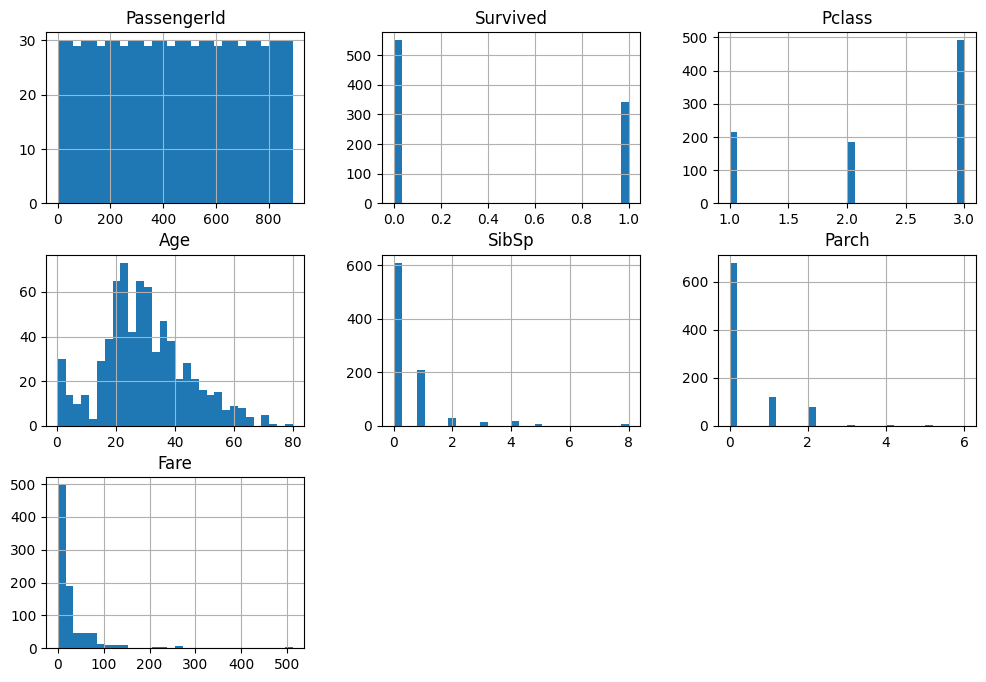

In [71]:
import matplotlib.pyplot as plt 
train.hist(bins=30, figsize=(12, 8), grid=True)
plt.show()


# Definir el taget 'Survived' y eliminar del grupo de entrenamiento

In [72]:
train.columns 

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [73]:
ytrain = train['Survived']
train = train.drop('Survived',axis=1)

# Eliminar columnas o variables que no aportan al entrenamiento

In [74]:
train = train.drop(['Name','Ticket','PassengerId','Cabin'], axis=1)

# Cabin tiene menos de la mitad de los datos 
# El resto son identificadores unicos que en este caso no aportan 

In [75]:
train.columns 

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')

In [76]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    object 
 2   Age       714 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Embarked  889 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 48.9+ KB


# Tratamiento de variables categoricas a numericas con OrdinalEncoder 

In [77]:
from sklearn.preprocessing import OrdinalEncoder 

listaCategoricas = ['Sex','Embarked']

# Crear el codificador
encoder = OrdinalEncoder()

# Aplicar la codificación solo a esas columnas
train[listaCategoricas] = encoder.fit_transform(train[listaCategoricas])

# Verificar resultado
train[listaCategoricas].head()


,Sex,Embarked
0,1.0,2.0
1,0.0,0.0
2,0.0,2.0
3,0.0,2.0
4,1.0,2.0


# Tratamiendo de datos faltantes SimpleImputer con mediana

In [78]:
from sklearn.impute import SimpleImputer

# columnas con NaN (ajusta si quieres otras)
listaFaltantes = ['Age', 'Embarked']

imputer = SimpleImputer(strategy='median')

train[listaFaltantes] = imputer.fit_transform(train[listaFaltantes])

# (Opcional) aplicar las mismas medianas al test
# test_df[listaFaltantes] = imputer.transform(test_df[listaFaltantes])

# Verifica
print(train[listaFaltantes].isna().sum())


Age         0
Embarked    0
dtype: int64


# Train sin categoricas y sin datos faltantes 

In [79]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    float64
 2   Age       891 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Embarked  891 non-null    float64
dtypes: float64(4), int64(3)
memory usage: 48.9 KB


## PCA
### Normalizar con StandardScaler Y Reduccion de dimencionalidad con PCA 

* ztrain guarda todas las coordenadas de las muestras en 2D (PC1, PC2). No está separado por clase.
* ytrain guarda la clase de cada muestra (0/1, etc.).
* plt.scatter(..., c=ytrain) solo usa ytrain para colorear cada punto según su clase; el gráfico no “almacena” clases.

ztrain es exactamente esa proyección: un array de tamaño (n_muestras, 2) con las coordenadas en:
* ztrain[:, 0] = PC1
* ztrain[:, 1] = PC2


ztrain = tus features transformadas por StandardScaler → PCA(2).
Es un array de forma (n_muestras, 2) con las coordenadas en PC1 y PC2.

ytrain = tu vector de etiquetas (clase objetivo) de forma (n_muestras,).

Relación: tienen el mismo orden de filas e igual número de muestras. Cada fila ztrain[i, :] corresponde a la etiqueta ytrain[i].
PCA no usa ytrain para calcularse (es no supervisado); ytrain solo se usa para colorear el scatter o para entrenar un clasificador después.

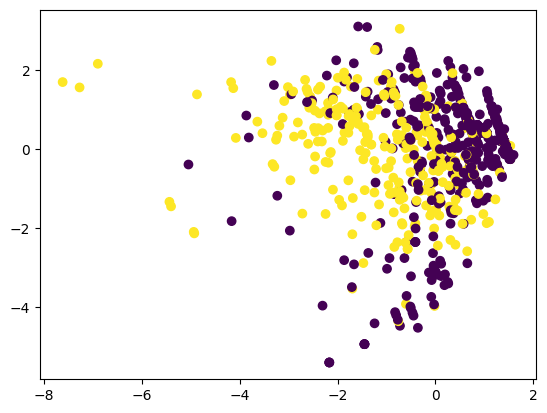

In [80]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sca_ = StandardScaler()           # 1) Estandariza: media 0, desv 1 por columna

red_ = PCA(n_components = 2)      # 2) PCA: toma las 2 direcciones de mayor varianza

ztrain = red_.fit_transform(sca_.fit_transform(train))
ztrain.shape
plt.scatter(ztrain[:,0],ztrain[:,1],c=ytrain)

## UMAP Reducción no lineal

In [81]:
#!pip install umap-learn #librería umap
#!pip install datashader bokeh holoviews #gráficos umap

[2025-10-29 04:09:22.432] [CUML] [info] build_algo set to brute_force_knn because random_state is given


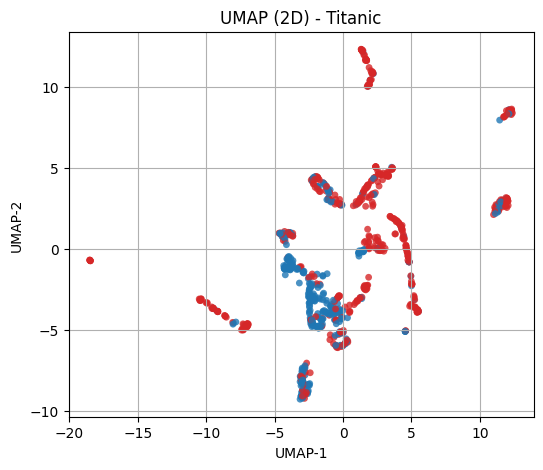

In [82]:
# ============================================
# UMAP: Reducción no lineal a 2D + visualización de supervivencia
# ============================================
#import matplotlib.pyplot as plt
#import numpy as np


import umap
from sklearn.preprocessing import StandardScaler
                                                                       
X_ = train.copy()                                   # 1) Features de entrada ya limpias (sin 'Survived', codificadas, sin NaN)                                                                   
y_clase = ytrain.to_numpy().ravel()                 # 2) Etiqueta binaria (0 = no sobrevivió, 1 = sobrevivió)
                                                                       
scaler = StandardScaler()                           # 3) Escalamiento (UMAP rinde mejor con datos estandarizados)
X_std = scaler.fit_transform(X_.astype(float))
                                                                        
umap_model = umap.UMAP(n_components=2, n_neighbors=40, min_dist=0.2, random_state=42)    # 4) Ajustar UMAP en CPU/GPU (según tu entorno) y proyectar a 2D
X_umap_2d = umap_model.fit_transform(X_std)   # shape: (n_muestras, 2)


# 5) Scatter plot de la proyección UMAP
#    Coloreamos las dos clases manualmente para que contraste más
colores = np.where(y_clase == 1, "tab:blue", "tab:red")

plt.figure(figsize=(6,5))
plt.scatter( X_umap_2d[:, 0], X_umap_2d[:, 1], c=colores, s=24, alpha=0.8, edgecolor="none")

plt.title("UMAP (2D) - Titanic")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.show()

# Nota:
# No usamos umap.plot.connectivity(umap_model, ...)
# porque en entornos con UMAP acelerado por GPU (cuml/cupy)
# esa función intenta convertir tensores GPU a NumPy y falla.


**Cada punto representa un pasajero del Titanic**, y su posición en el plano UMAP depende de su **similitud** con los demás pasajeros en función de las variables del dataset (edad, clase, tarifa, sexo, embarque, etc.)

**1. Ejes UMAP-1 y UMAP-2:**
No tienen una interpretación física (no son “edad” ni “tarifa”), sino componentes latentes que UMAP calcula para preservar relaciones de vecindad entre observaciones.

* Si dos puntos están cerca, significa que los pasajeros son similares en sus características originales.
* Si están lejos, son distintos (por ejemplo, edades o clases muy diferentes).

**2. Color:**

* Azul = pasajero **sobrevivió (1)**
* Rojo = pasajero **no sobrevivió (0)**


Esto implica que UMAP logró reflejar, aunque no de manera perfecta, una separación latente entre las clases.

Esto sugiere que variables como la clase, el sexo o la edad influyen en la probabilidad de supervivencia y que UMAP logra capturar parcialmente esa estructura de los datos.

# 2 ___ Particionar el conjunto de entrenamiento train_test_split 80/20 Nuevo 

* X_tr → features (entradas) del 80% para entrenar
* y_tr → etiquetas reales del 80% (supervivió/no sobrevivió)
* X_te → features del 20% que guardaste aparte (nunca vistas durante el entrenamiento)
* y_te → etiquetas reales del 20% (la verdad de ese 20%)


Dividimos el dataset en un conjunto de entrenamiento (80%) y uno de validación hold-out (20%).
Entrenamos cada clasificador únicamente con (X_tr, y_tr) y luego generamos predicciones en X_te, que el modelo no había visto antes.
Finalmente, comparamos esas predicciones con las etiquetas reales y_te para obtener las métricas de desempeño (accuracy, matriz de confusión, reporte de clasificación, curva ROC y AUC).

In [83]:
from sklearn.model_selection import train_test_split

# X son las features finales que vas a usar.
# En tu cuaderno tienes dos opciones razonables:
# 1) usar 'train' ya limpio (sin Survived, sin Name, etc.)
# 2) usar 'ztrain' que es PCA(2) -> ya escalado+reducido


X = train         # shape (n_samples, n_features_reducidas)
y = ytrain.values  # vector 0/1

# split 80/20 estratificado para mantener proporción de clases
# X_tr, y_tr: lo usas para entrenar el modelo.
# X_te, y_te: lo usas para medir desempeño final rápido (accuracy, f1, etc.) con model.score() o classification_report.

X_tr, X_te, y_tr, y_te = train_test_split(X, y,test_size=0.2,stratify=y,random_state=42) 

print("Entrenamiento:", X_tr.shape, y_tr.shape)
print("Validación  :", X_te.shape, y_te.shape)


Entrenamiento: (712, 7) (712,)
Validación  : (179, 7) (179,)


Perfecto, ya hiciste la partición 80/20 y ya tienes:

X_tr, X_te, y_tr, y_te


donde:

X_tr, y_tr = se usan para entrenar
X_te, y_te = se usan para evaluar

Ahora vamos a construir la Parte 2: entrenar clasificadores de la forma más clara, ordenada y parecida al estilo de clase que estás usando (QDA, SVM, árboles, etc.). Voy a darte un bloque que puedes pegar tal cual en tu notebook después del train_test_split.

Objetivo de este bloque

Definir una lista de modelos clasificadores típicos.

Entrenar cada modelo con X_tr, y_tr.

Predecir en X_te.

Guardar todo (predicciones, probabilidades) para luego, en la Parte 3, calcular matriz de confusión, métricas y ROC.

Así dejas tu notebook bien modular:
Parte 1: split
Parte 2: entrenar modelos y obtener predicciones
Parte 3: métricas/reportes/ROC

# Entrenamiento de clasificadores y predicción en el 20%

Queremos calcular la curva ROC y el AUC para cada clasificador.
Para eso necesitamos un puntaje continuo y_score que refleje “qué tan probable es que el pasajero pertenezca a la clase positiva (sobrevive = 1)”.

Si el modelo entrega probabilidades (predict_proba), usamos la probabilidad de la clase 1.

Si el modelo no da probabilidades pero sí da una función de decisión (decision_function), usamos ese valor continuo (distancia al hiperplano, etc.).

Si no hay ninguna de las dos cosas, como último recurso usamos la clase predicha (0 ó 1), aunque eso hace que la ROC pierda detalle.

In [84]:
# ============================================
# Clasificadores clásicos sobre Titanic
# Entrenamiento con 80% y predicción en 20%
# ============================================

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier

# 1. Definimos los modelos que queremos probar
modelos = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "SVM_lineal":         SVC(kernel='linear', probability=True, random_state=42),
    "SVM_RBF":            SVC(kernel='rbf', probability=True, random_state=42),
    "KNN_5":              KNeighborsClassifier(n_neighbors=5),
    "LDA":                LinearDiscriminantAnalysis(),
    "QDA":                QuadraticDiscriminantAnalysis(),
    "ArbolDecision":      DecisionTreeClassifier(max_depth=None, random_state=42)
}

# 2. Entrenamos cada modelo con el conjunto de entrenamiento (80%)
#    y generamos predicciones sobre el conjunto de validación (20%)
resultados_modelos = {}  # acá vamos a guardar todo para usarlos en la Parte 3

for nombre, modelo in modelos.items():
    # Entrenar
    modelo.fit(X_tr, y_tr)

    # Predicción de clase (0/1) en el 20%
    y_pred = modelo.predict(X_te)

    # Puntaje continuo tipo "probabilidad de clase 1"
    # Esto lo necesito luego para la curva ROC / AUC.
    # - Si el modelo tiene predict_proba, usamos la columna de la clase positiva.
    # - Si NO tiene predict_proba pero sí decision_function (ej. SVM sin probability=False),
    #   usamos decision_function.
    if hasattr(modelo, "predict_proba"):             #verifica si un objeto tiene un atributo o método con ese nombre, devolviendo True o False
        y_score = modelo.predict_proba(X_te)[:, 1]  # prob. de clase 1 (sobrevive)
    elif hasattr(modelo, "decision_function"):
        y_score = modelo.decision_function(X_te)
    else:
        # Fallback: usamos la predicción discreta como score (menos ideal para ROC)
        y_score = y_pred.astype(float)

    # Guardamos todo lo relevante para evaluación posterior
    resultados_modelos[nombre] = {
        "modelo": modelo,
        "y_pred": y_pred,
        "y_score": y_score
    }

# 3. Vistazo rápido: modelos entrenados
print("Modelos entrenados y listos para evaluar:")
for nombre in resultados_modelos.keys():
    print(" -", nombre)


Modelos entrenados y listos para evaluar:
 - LogisticRegression
 - SVM_lineal
 - SVM_RBF
 - KNN_5
 - LDA
 - QDA
 - ArbolDecision


# Evaluación de los modelos en el 20% hold-out

 Evaluación de los modelos en el 20% hold-out
- Accuracy
- Classification report
- Matriz de confusión
- Curva ROC y AUC

Modelo: LogisticRegression
Accuracy: 0.804
Classification report:
              precision    recall  f1-score   support

           0      0.810     0.891     0.848       110
           1      0.793     0.667     0.724        69

    accuracy                          0.804       179
   macro avg      0.802     0.779     0.786       179
weighted avg      0.803     0.804     0.801       179



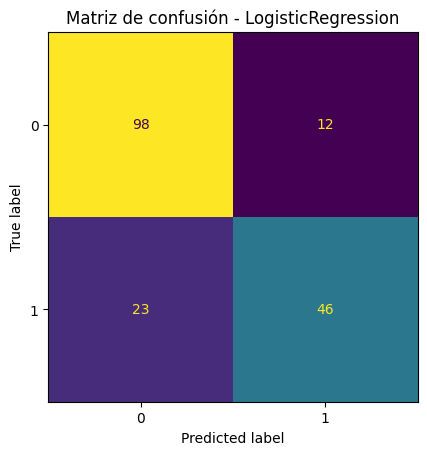

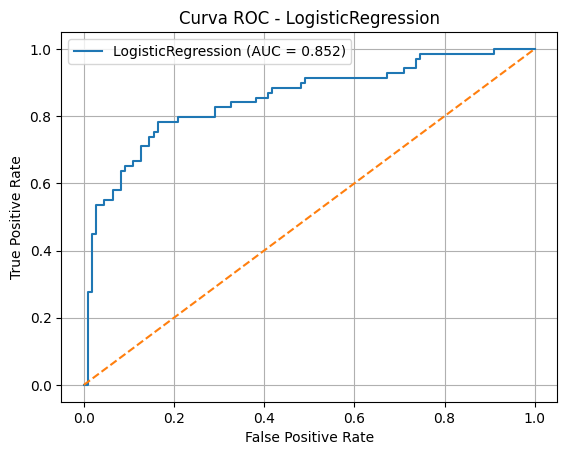

Modelo: SVM_lineal
Accuracy: 0.777
Classification report:
              precision    recall  f1-score   support

           0      0.797     0.855     0.825       110
           1      0.738     0.652     0.692        69

    accuracy                          0.777       179
   macro avg      0.767     0.753     0.758       179
weighted avg      0.774     0.777     0.774       179



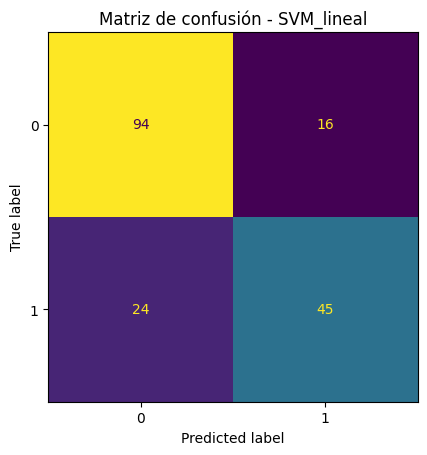

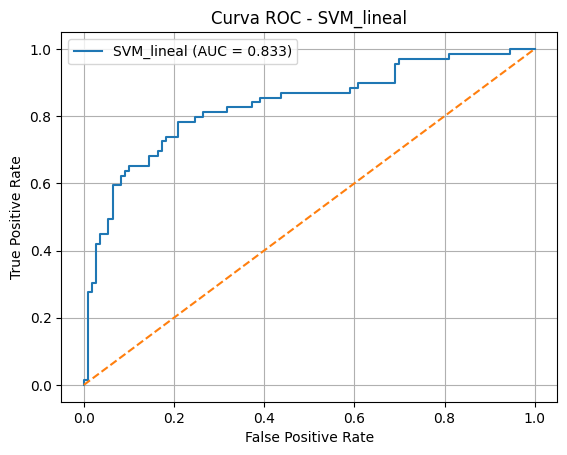

Modelo: SVM_RBF
Accuracy: 0.620
Classification report:
              precision    recall  f1-score   support

           0      0.642     0.864     0.736       110
           1      0.516     0.232     0.320        69

    accuracy                          0.620       179
   macro avg      0.579     0.548     0.528       179
weighted avg      0.593     0.620     0.576       179



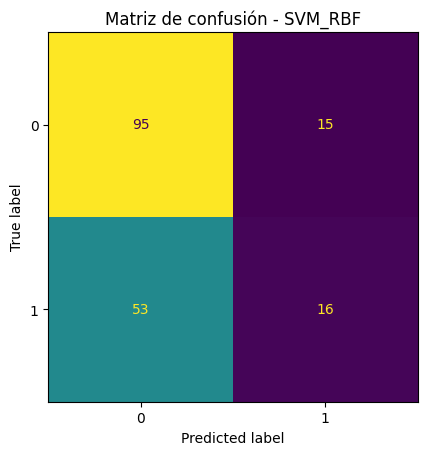

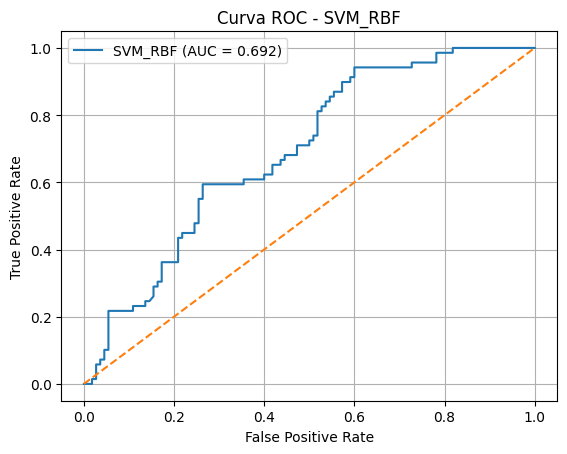

Modelo: KNN_5
Accuracy: 0.648
Classification report:
              precision    recall  f1-score   support

           0      0.701     0.745     0.722       110
           1      0.548     0.493     0.519        69

    accuracy                          0.648       179
   macro avg      0.625     0.619     0.621       179
weighted avg      0.642     0.648     0.644       179



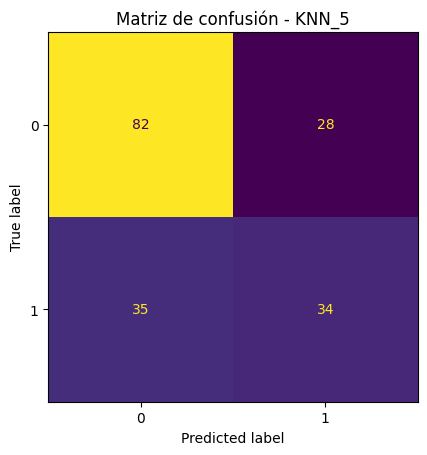

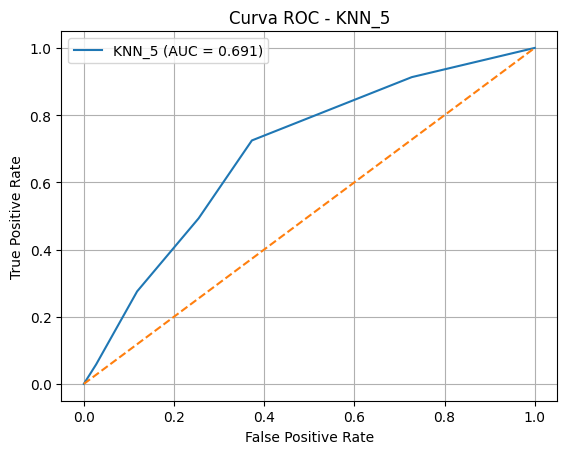

Modelo: LDA
Accuracy: 0.793
Classification report:
              precision    recall  f1-score   support

           0      0.812     0.864     0.837       110
           1      0.758     0.681     0.718        69

    accuracy                          0.793       179
   macro avg      0.785     0.772     0.777       179
weighted avg      0.791     0.793     0.791       179



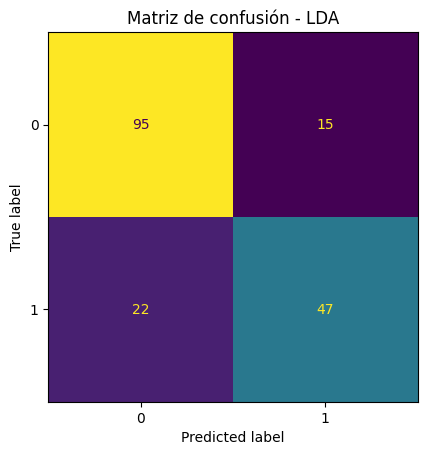

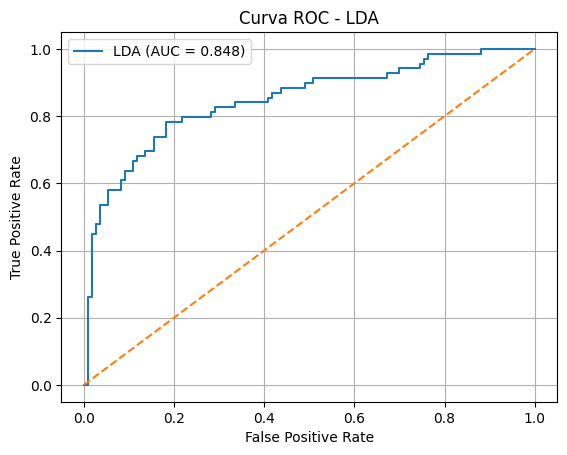

Modelo: QDA
Accuracy: 0.804
Classification report:
              precision    recall  f1-score   support

           0      0.810     0.891     0.848       110
           1      0.793     0.667     0.724        69

    accuracy                          0.804       179
   macro avg      0.802     0.779     0.786       179
weighted avg      0.803     0.804     0.801       179



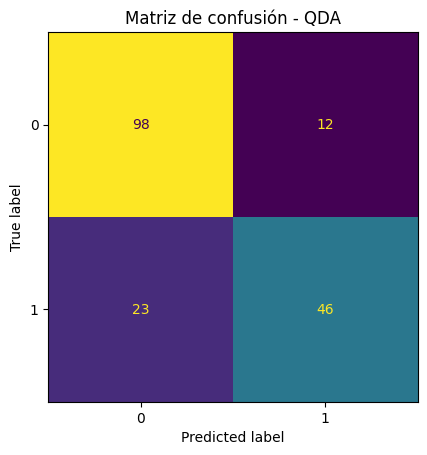

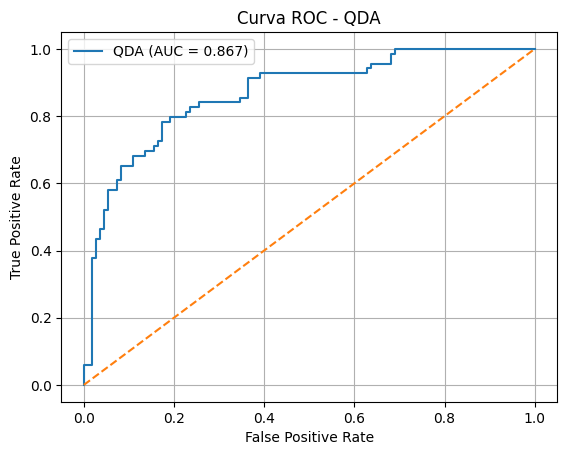

Modelo: ArbolDecision
Accuracy: 0.832
Classification report:
              precision    recall  f1-score   support

           0      0.851     0.882     0.866       110
           1      0.800     0.754     0.776        69

    accuracy                          0.832       179
   macro avg      0.825     0.818     0.821       179
weighted avg      0.831     0.832     0.831       179



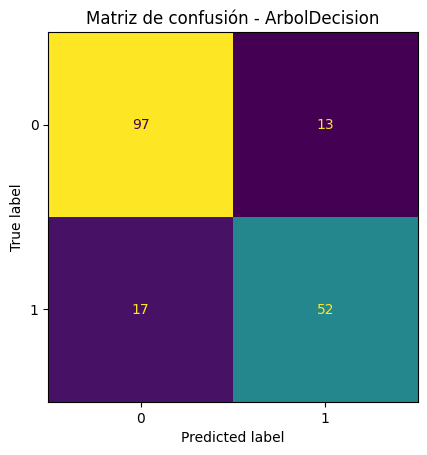

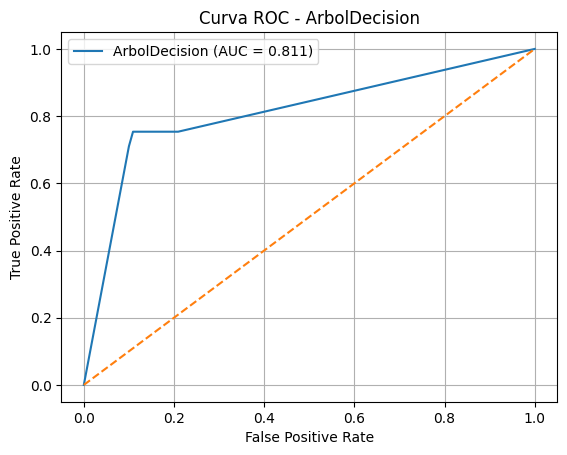

In [85]:
# ============================================

# ============================================

from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    accuracy_score,
    roc_curve,
    auc
)
import matplotlib.pyplot as plt

for nombre, info in resultados_modelos.items():
    print("====================================")
    print(f"Modelo: {nombre}")
    print("====================================")

    y_pred  = info["y_pred"]    # clases predichas (0/1)
    y_score = info["y_score"]   # probabilidad o score continuo de clase 1

    # 1. Accuracy y classification report
    acc = accuracy_score(y_te, y_pred)
    print(f"Accuracy: {acc:.3f}")

    print("Classification report:")
    print(classification_report(y_te, y_pred, digits=3))
    # esto imprime precision, recall y f1 para cada clase,
    # más el 'macro avg' y 'weighted avg'

    # 2. Matriz de confusión
    cm = confusion_matrix(y_te, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(colorbar=False)
    plt.title(f"Matriz de confusión - {nombre}")
    plt.show()

    # 3. Curva ROC y AUC
    #    Nota: necesitamos un score continuo. Si un modelo no tiene 'predict_proba'
    #    usamos 'decision_function' en el paso anterior, y si no tenía nada,
    #    usamos las clases (peor caso).
    fpr, tpr, thr = roc_curve(y_te, y_score)
    auc_score = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f"{nombre} (AUC = {auc_score:.3f})")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Curva ROC - {nombre}")
    plt.legend()
    plt.grid(True)
    plt.show()


# Resumen de desempeño en el conjunto de validación (20%)

* En la evaluación realizada sobre el conjunto de validación (20 %), los modelos que mostraron mejor desempeño general fueron QDA (AUC = 0.867) y Regresión Logística (AUC = 0.852), seguidos muy de cerca por LDA (AUC = 0.848).
* Estos tres clasificadores presentan un equilibrio adecuado entre precisión y sensibilidad, con valores de accuracy cercanos al 80 %.
El modelo SVM lineal también obtuvo un rendimiento aceptable (AUC = 0.833), mientras que el Árbol de decisión logró una precisión alta pero con menor estabilidad (AUC = 0.811).
* Por el contrario, SVM con kernel RBF y KNN evidenciaron menor capacidad discriminante (AUC ≈ 0.69), probablemente debido a una sobreajuste local o falta de ajuste óptimo de parámetros.

In [86]:
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc
)

resumen_filas = []

for nombre, info in resultados_modelos.items():
    y_pred  = info["y_pred"]
    y_score = info["y_score"]
    
    # métricas clase positiva = 1 (sobrevivió)
    acc  = accuracy_score(y_te, y_pred)
    prec = precision_score(y_te, y_pred, pos_label=1, zero_division=0)
    rec  = recall_score(y_te, y_pred,    pos_label=1, zero_division=0)
    f1   = f1_score(y_te, y_pred,        pos_label=1, zero_division=0)

    # curva ROC y AUC
    fpr, tpr, thr = roc_curve(y_te, y_score)
    auc_score = auc(fpr, tpr)

    resumen_filas.append({
        "Modelo": nombre,
        "Accuracy": acc,
        "Precision_1": prec,
        "Recall_1": rec,
        "F1_1": f1,
        "AUC_ROC": auc_score
    })

tabla_resumen = pd.DataFrame(resumen_filas)
tabla_resumen = tabla_resumen.sort_values(by="AUC_ROC", ascending=False).reset_index(drop=True)

print("=== Resumen de desempeño en el conjunto de validación (20%) ===")
display(tabla_resumen.round(3))


=== Resumen de desempeño en el conjunto de validación (20%) ===


,Modelo,Accuracy,Precision_1,Recall_1,F1_1,AUC_ROC
0,QDA,0.804,0.793,0.667,0.724,0.867
1,LogisticRegression,0.804,0.793,0.667,0.724,0.852
2,LDA,0.793,0.758,0.681,0.718,0.848
3,SVM_lineal,0.777,0.738,0.652,0.692,0.833
4,ArbolDecision,0.832,0.800,0.754,0.776,0.811
5,SVM_RBF,0.620,0.516,0.232,0.320,0.692
6,KNN_5,0.648,0.548,0.493,0.519,0.691


# Curvas ROC - Comparación de modelos (validación 20%)

**La gráfica muestra las curvas ROC**
(Receiver Operating Characteristic) de los distintos modelos clasificadores evaluados sobre el conjunto de validación (20 % de los datos).
Cada curva representa la relación entre la tasa de verdaderos positivos (TPR) y la tasa de falsos positivos (FPR) a medida que varía el umbral de decisión del modelo.
El área bajo la curva (AUC) cuantifica la capacidad del modelo para distinguir correctamente entre pasajeros que sobrevivieron y los que no: cuanto mayor es el AUC, mejor es el desempeño global del clasificador.

**En los resultados observados:**
* El QDA (AUC = 0.867) presenta el mejor poder discriminante, seguido muy de cerca por la Regresión Logística (AUC = 0.852) y el LDA (AUC = 0.848).
* El SVM lineal (AUC = 0.833) y el Árbol de decisión (AUC = 0.811) muestran también un comportamiento sólido, aunque ligeramente inferior.
* En contraste, el SVM con kernel RBF (AUC = 0.692) y el KNN (AUC = 0.691) evidencian menor capacidad para separar las clases, reflejando un mayor solapamiento entre sobrevivientes y no sobrevivientes.

En general, los modelos lineales (Regresión Logística, LDA, SVM lineal) logran un equilibrio adecuado entre sensibilidad y especificidad, manteniendo curvas alejadas de la diagonal (clasificador aleatorio).
Esto indica que son los más consistentes para predecir la probabilidad de supervivencia en este conjunto de datos.

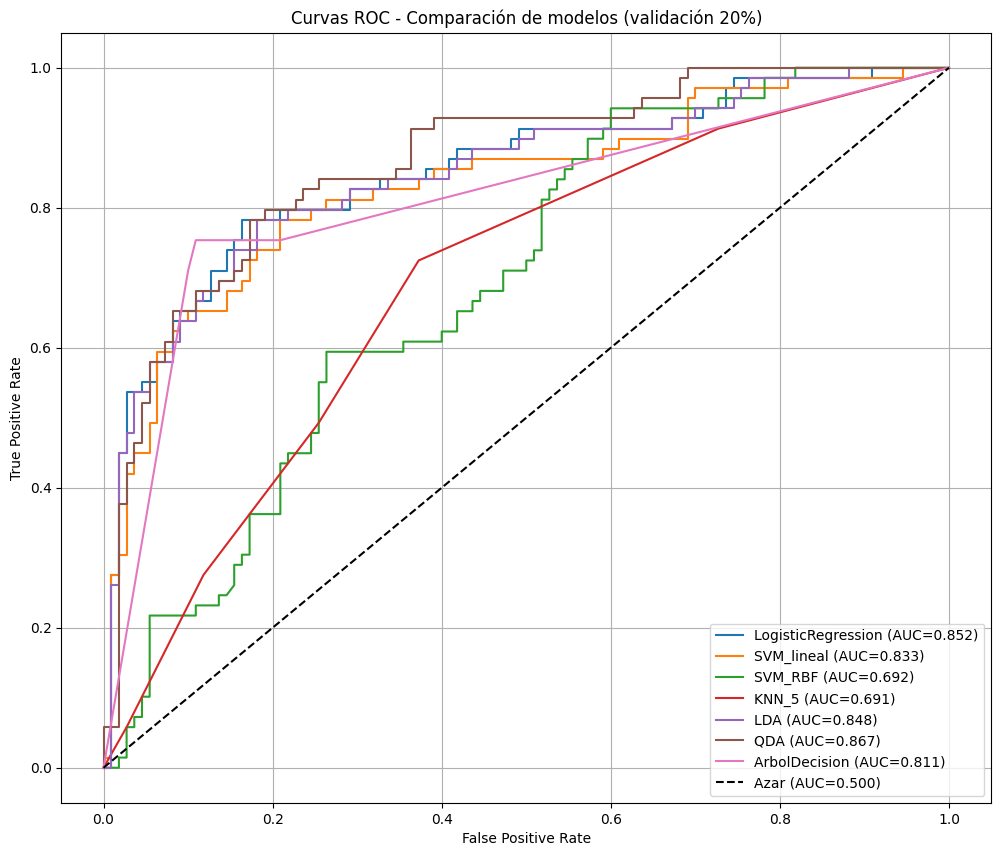

In [87]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(12,10))

for nombre, info in resultados_modelos.items():
    y_score = info["y_score"]
    
    # si el modelo no tuvo score continuo y estamos usando 0/1 como score,
    # la curva ROC va a salir como un escalón raro, pero igual la graficamos
    fpr, tpr, thr = roc_curve(y_te, y_score)
    auc_score = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f"{nombre} (AUC={auc_score:.3f})")

# línea base (clasificador aleatorio)
plt.plot([0,1], [0,1], 'k--', label="Azar (AUC=0.500)")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC - Comparación de modelos (validación 20%)")
plt.grid(True)
plt.legend(loc="lower right")
plt.show()


# Validación cruzada estratificada (K = 5)

* En la validación cruzada estratificada (K = 5), los resultados confirman la estabilidad de los modelos lineales.
* Los valores promedio de accuracy y AUC se mantienen consistentes entre folds, destacándose nuevamente SVM RBF (AUC = 0.855), Regresión Logística (AUC = 0.853) y LDA (AUC = 0.853) como los modelos más balanceados y generalizables.
* Las desviaciones estándar bajas (≈ 0.02) en las métricas de estos modelos sugieren un comportamiento robusto frente a la variación de los datos.
* En contraste, el Árbol de Decisión muestra mayor variabilidad (AUC_std = 0.031), indicando menor consistencia entre particiones.

In [88]:
# ============================================
# Validación cruzada estratificada (K = 5)
# Comparación de modelos con métricas promedio
# ============================================

import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier

# 1. Volvemos a definir X e y completos (todas las filas, SIN el split 80/20)
#    Nota: usamos la misma 'train' limpia que ya construiste antes
X_full = train.copy()
y_full = ytrain.to_numpy().ravel()

# 2. Definimos los modelos igual que antes.
#    Para SVM queremos probability=True si luego medimos AUC ROC.
#    la lista de modelos esta definida en el bloque de entrenamiento. 

# 3. Definimos las métricas que queremos medir en la CV
#    - accuracy
#    - precision (clase positiva = 1, sobrevivió)
#    - recall    (clase positiva = 1)
#    - f1        (clase positiva = 1)
#    - roc_auc   (AUC de la curva ROC)
scoring = {
    "accuracy":  make_scorer(accuracy_score),
    "precision": make_scorer(precision_score, pos_label=1, zero_division=0),
    "recall":    make_scorer(recall_score,    pos_label=1, zero_division=0),
    "f1":        make_scorer(f1_score,        pos_label=1, zero_division=0),
    "roc_auc":   make_scorer(roc_auc_score, needs_threshold=True)
}

# 4. Definimos el esquema de validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)                    # validación cruzada

# 5. Para cada modelo:
#    - armamos un Pipeline con StandardScaler() cuando hace falta
#    - corremos cross_validate en las 5 particiones
#    - almacenamos los promedios y desviaciones estándar
filas_resumen_cv = []

for nombre, modelo in modelos.items():
    # Algunos clasificadores (LogReg, SVM, KNN) se benefician de escalar las variables.
    # Otros (árbol, QDA, LDA) también pueden usar los datos crudos, pero escalar no les hace daño aquí.
    # Para mantenerlo simple y homogéneo, metemos todo en un Pipeline: [Scaler -> Modelo]
    
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", modelo)
    ])

    scores = cross_validate(pipeline, X_full, y_full, cv=cv, scoring=scoring, return_train_score=False)  # validación cruzada

    filas_resumen_cv.append({
        "Modelo": nombre,
        "ACC_mean":     np.mean(scores["test_accuracy"]),
        "ACC_std":      np.std(scores["test_accuracy"]),
        "F1_mean":      np.mean(scores["test_f1"]),
        "F1_std":       np.std(scores["test_f1"]),
        "Recall_mean":  np.mean(scores["test_recall"]),
        "Precision_mean": np.mean(scores["test_precision"]),
        "ROC_AUC_mean": np.mean(scores["test_roc_auc"]),
        "ROC_AUC_std":  np.std(scores["test_roc_auc"])
    })

tabla_cv = pd.DataFrame(filas_resumen_cv)
tabla_cv = tabla_cv.sort_values(by="ROC_AUC_mean", ascending=False).reset_index(drop=True)

print("=== Validación Cruzada Estratificada (K=5) ===")
display(tabla_cv.round(3))


[2025-10-29 04:10:03.375] [CUML] [info] Unused keyword parameter: dual during cuML estimator initialization
[2025-10-29 04:10:03.375] [CUML] [info] Unused keyword parameter: intercept_scaling during cuML estimator initialization
[2025-10-29 04:10:03.375] [CUML] [info] Unused keyword parameter: multi_class during cuML estimator initialization
[2025-10-29 04:10:03.375] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-10-29 04:10:03.375] [CUML] [info] Unused keyword parameter: random_state during cuML estimator initialization
[2025-10-29 04:10:03.375] [CUML] [info] Unused keyword parameter: warm_start during cuML estimator initialization
=== Validación Cruzada Estratificada (K=5) ===


,Modelo,ACC_mean,ACC_std,F1_mean,F1_std,Recall_mean,Precision_mean,ROC_AUC_mean,ROC_AUC_std
0,SVM_RBF,0.827,0.019,0.752,0.032,0.687,0.836,0.855,0.014
1,LogisticRegression,0.791,0.019,0.720,0.025,0.702,0.743,0.853,0.022
2,LDA,0.797,0.019,0.726,0.024,0.702,0.755,0.853,0.023
3,KNN_5,0.809,0.017,0.745,0.024,0.728,0.766,0.851,0.022
4,QDA,0.789,0.010,0.716,0.019,0.696,0.741,0.846,0.008
5,SVM_lineal,0.787,0.019,0.709,0.032,0.681,0.743,0.824,0.023
6,ArbolDecision,0.785,0.033,0.721,0.043,0.728,0.716,0.776,0.031


# Optimización de hiperparámetros Búsqueda en rejilla (tipo Grid Search) con CV manual
Se implementó una búsqueda exhaustiva de hiperparámetros (tipo Grid Search) con validación cruzada estratificada de 5 folds para cada modelo.
Dado que el entorno de ejecución utiliza aceleración GPU (cuML), algunas combinaciones de hiperparámetros no son compatibles con ciertas implementaciones (por ejemplo, weights="distance" en KNN).
Para resolverlo, se evaluaron todas las combinaciones válidas y se descartaron automáticamente aquellas que generaron incompatibilidades.

Para cada modelo se reporta:

* El mejor conjunto de hiperparámetros encontrado.
* El AUC ROC promedio en CV asociado a esa mejor configuración.

Esto permite comparar no solo cuál modelo generaliza mejor, sino también cuáles hiperparámetros son más adecuados para el conjunto Titanic.

In [89]:
# ============================================
# Búsqueda en rejilla (tipo Grid Search) con CV manual
# compatible con cuML
# ============================================

import itertools
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier

# 1. Datos completos
X_full = train.copy()
y_full = ytrain.to_numpy().ravel()

# 2. CV y métrica a optimizar
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring_auc = {"roc_auc": make_scorer(roc_auc_score, needs_threshold=True)}

# 3. Modelos base
modelos_para_grid = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "SVM_lineal":         SVC(kernel="linear", probability=True, random_state=42),
    "SVM_RBF":            SVC(kernel="rbf", probability=True, random_state=42),
    "KNN":                KNeighborsClassifier(),
    "LDA":                LinearDiscriminantAnalysis(),
    "QDA":                QuadraticDiscriminantAnalysis(),
    "ArbolDecision":      DecisionTreeClassifier(random_state=42)
}

# 4. Rejillas de hiperparámetros
#    Ajuste importante: KNN solo usa 'uniform' porque 'distance' rompe en cuML
rejillas = {
    "LogisticRegression": {
        "clf__C":        [0.01, 0.1, 1, 10, 100],
        "clf__penalty":  ["l2"],
        "clf__solver":   ["lbfgs"]
    },
    "SVM_lineal": {
        "clf__C":      [0.1, 1, 10],
        "clf__kernel": ["linear"]
    },
    "SVM_RBF": {
        "clf__C":    [0.1, 1, 10],
        "clf__gamma": ["scale", "auto"]
    },
    "KNN": {
        "clf__n_neighbors": [3,5,7,9,11],
        "clf__weights":     ["uniform"]   # <- importante cambio
    },
    "LDA": {
        "clf__solver": ["svd", "lsqr", "eigen"]
    },
    "QDA": {
        "clf__reg_param": [0.0, 0.1, 0.25, 0.5]
    },
    "ArbolDecision": {
        "clf__criterion":          ["gini", "entropy"],
        "clf__max_depth":          [3,5,7,None],
        "clf__min_samples_split":  [2,5,10]
    }
}

# 5. Helper para expandir la rejilla a combinaciones
def expand_grid(grid_dict):
    keys = list(grid_dict.keys())
    values_product = itertools.product(*[grid_dict[k] for k in keys])
    for combo in values_product:
        yield dict(zip(keys, combo))

resultados_todas = []    # TODAS las combinaciones válidas evaluadas
mejores_por_modelo = []  # El mejor set por modelo

for nombre_modelo, estimador_base in modelos_para_grid.items():
    print(f"\n Tuning manual CV -> {nombre_modelo}")

    mejor_auc = -np.inf
    mejor_params = None

    for params in expand_grid(rejillas[nombre_modelo]):
        # Creamos el clasificador con esa combinación de hiperparámetros.
        # OJO: params tiene claves tipo "clf__C", hay que quitar el "clf__"
        clf_kwargs = {k.replace("clf__", ""): v for k,v in params.items()}

        try:
            pipe = Pipeline([
                ("scaler", StandardScaler()),
                ("clf", estimador_base.__class__(**clf_kwargs))
            ])

            scores = cross_validate(
                pipe,
                X_full,
                y_full,
                cv=cv,
                scoring=scoring_auc,
                return_train_score=False
            )

        except Exception as e:
            # Si cuML/no soporta esa combinación, la saltamos sin frenar todo
            print(f"    Saltando combinación inválida {params} -> {e}")
            continue

        auc_mean = scores["test_roc_auc"].mean()
        auc_std  = scores["test_roc_auc"].std()

        resultados_todas.append({
            "Modelo": nombre_modelo,
            "Params": params,
            "AUC_mean": auc_mean,
            "AUC_std": auc_std
        })

        if auc_mean > mejor_auc:
            mejor_auc = auc_mean
            mejor_params = params

    mejores_por_modelo.append({
        "Modelo": nombre_modelo,
        "Best_AUC_mean": mejor_auc,
        "Best_Params": mejor_params
    })

# 6. Tablas finales ordenadas
tabla_todas = pd.DataFrame(resultados_todas).sort_values(by="AUC_mean", ascending=False)
tabla_mejores = pd.DataFrame(mejores_por_modelo).sort_values(by="Best_AUC_mean", ascending=False)

print("=== Todas las combinaciones evaluadas (top 10) ===")
display(tabla_todas.head(5).round(3))

print("=== Mejor configuración por modelo ===")
display(tabla_mejores.round(3))



 Tuning manual CV -> LogisticRegression

 Tuning manual CV -> SVM_lineal

 Tuning manual CV -> SVM_RBF

 Tuning manual CV -> KNN

 Tuning manual CV -> LDA

 Tuning manual CV -> QDA

 Tuning manual CV -> ArbolDecision
=== Todas las combinaciones evaluadas (top 10) ===


,Modelo,Params,AUC_mean,AUC_std
16,KNN,"{'clf__n_neighbors': 7, 'clf__weights': 'unifo...",0.860,0.021
17,KNN,"{'clf__n_neighbors': 9, 'clf__weights': 'unifo...",0.859,0.020
18,KNN,"{'clf__n_neighbors': 11, 'clf__weights': 'unif...",0.857,0.025
26,ArbolDecision,"{'clf__criterion': 'gini', 'clf__max_depth': 3...",0.856,0.030
28,ArbolDecision,"{'clf__criterion': 'gini', 'clf__max_depth': 3...",0.856,0.030


=== Mejor configuración por modelo ===


,Modelo,Best_AUC_mean,Best_Params
3,KNN,0.860,"{'clf__n_neighbors': 7, 'clf__weights': 'unifo..."
6,ArbolDecision,0.856,"{'clf__criterion': 'gini', 'clf__max_depth': 3..."
2,SVM_RBF,0.855,"{'clf__C': 1, 'clf__gamma': 'scale'}"
0,LogisticRegression,0.853,"{'clf__C': 1, 'clf__penalty': 'l2', 'clf__solv..."
4,LDA,0.853,{'clf__solver': 'svd'}
5,QDA,0.847,{'clf__reg_param': 0.25}
1,SVM_lineal,0.824,"{'clf__C': 1, 'clf__kernel': 'linear'}"


In [90]:
# ============================================
# Optimización Bayesiana con Optuna (para todos los modelos)
# ============================================

!pip install optuna -q

import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, make_scorer

# CV y métrica
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = make_scorer(roc_auc_score, needs_threshold=True)

# Modelos base
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier

modelos = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "SVM_lineal":         SVC(kernel="linear", probability=True, random_state=42),
    "SVM_RBF":            SVC(kernel="rbf", probability=True, random_state=42),
    "KNN":                KNeighborsClassifier(),
    "LDA":                LinearDiscriminantAnalysis(),
    "QDA":                QuadraticDiscriminantAnalysis(),
    "ArbolDecision":      DecisionTreeClassifier(random_state=42)
}

# Datos
X_full = train.copy()
y_full = ytrain.to_numpy().ravel()

# Resultados
resultados_optuna = []

for nombre, modelo in modelos.items():
    print(f"\n=== Optuna -> {nombre} ===")

    # Define el espacio de búsqueda de hiperparámetros
    def objective(trial):

        if nombre == "LogisticRegression":
            C = trial.suggest_float("C", 1e-3, 1e2, log=True)
            clf = LogisticRegression(C=C, max_iter=1000)

        elif nombre == "SVM_lineal":
            C = trial.suggest_float("C", 1e-3, 1e2, log=True)
            clf = SVC(kernel="linear", C=C, probability=True)

        elif nombre == "SVM_RBF":
            C = trial.suggest_float("C", 1e-3, 1e2, log=True)
            gamma = trial.suggest_float("gamma", 1e-4, 1, log=True)
            clf = SVC(kernel="rbf", C=C, gamma=gamma, probability=True)

        elif nombre == "KNN":
            n_neighbors = trial.suggest_int("n_neighbors", 3, 15)
            clf = KNeighborsClassifier(n_neighbors=n_neighbors, weights="uniform")

        elif nombre == "LDA":
            solver = trial.suggest_categorical("solver", ["svd", "lsqr", "eigen"])
            clf = LinearDiscriminantAnalysis(solver=solver)

        elif nombre == "QDA":
            reg_param = trial.suggest_float("reg_param", 0.0, 1.0)
            clf = QuadraticDiscriminantAnalysis(reg_param=reg_param)

        elif nombre == "ArbolDecision":
            max_depth = trial.suggest_int("max_depth", 2, 15)
            min_split = trial.suggest_int("min_samples_split", 2, 20)
            criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
            clf = DecisionTreeClassifier(max_depth=max_depth,
                                         min_samples_split=min_split,
                                         criterion=criterion)

        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("clf", clf)
        ])

        scores = cross_val_score(pipe, X_full, y_full, cv=cv, scoring=scoring)
        return scores.mean()

    # Ejecutar optimización bayesiana
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=20, show_progress_bar=True)

    resultados_optuna.append({
        "Modelo": nombre,
        "Best_AUC_CV": study.best_value,
        "Best_Params": study.best_params
    })

# Tabla final
import pandas as pd
tabla_optuna = pd.DataFrame(resultados_optuna).sort_values(by="Best_AUC_CV", ascending=False)
display(tabla_optuna.round(3))


[I 2025-10-29 04:10:09,956] A new study created in memory with name: no-name-7b92bfb8-45ce-4308-a8ed-ea1744db649d



=== Optuna -> LogisticRegression ===


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-10-29 04:10:10,059] Trial 0 finished with value: 0.8532590422396613 and parameters: {'C': 16.04303542940312}. Best is trial 0 with value: 0.8532590422396613.
[I 2025-10-29 04:10:10,143] Trial 1 finished with value: 0.8532857802075757 and parameters: {'C': 5.017596574098515}. Best is trial 1 with value: 0.8532857802075757.
[I 2025-10-29 04:10:10,227] Trial 2 finished with value: 0.8530994854336557 and parameters: {'C': 0.28376946335067477}. Best is trial 1 with value: 0.8532857802075757.
[I 2025-10-29 04:10:10,309] Trial 3 finished with value: 0.853152477874785 and parameters: {'C': 0.3306990089916681}. Best is trial 1 with value: 0.8532857802075757.
[I 2025-10-29 04:10:10,379] Trial 4 finished with value: 0.8440795078592777 and parameters: {'C': 0.002557616101334039}. Best is trial 1 with value: 0.8532857802075757.
[I 2025-10-29 04:10:10,462] Trial 5 finished with value: 0.853445820508281 and parameters: {'C': 0.948104372039665}. Best is trial 5 with value: 0.853445820508281.
[

[I 2025-10-29 04:10:11,578] A new study created in memory with name: no-name-72b4d499-fe9d-4ef9-aca7-8310babc78ca


[I 2025-10-29 04:10:11,492] Trial 18 finished with value: 0.8519728112443803 and parameters: {'C': 0.01514403526850224}. Best is trial 10 with value: 0.8537388716229138.
[I 2025-10-29 04:10:11,577] Trial 19 finished with value: 0.8529151281936425 and parameters: {'C': 0.15040687978494702}. Best is trial 10 with value: 0.8537388716229138.

=== Optuna -> SVM_lineal ===


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-10-29 04:10:14,131] Trial 0 finished with value: 0.8165151586253676 and parameters: {'C': 38.88741516168312}. Best is trial 0 with value: 0.8165151586253676.
[I 2025-10-29 04:10:14,350] Trial 1 finished with value: 0.8496959991524623 and parameters: {'C': 0.0018468223696913387}. Best is trial 1 with value: 0.8496959991524623.
[I 2025-10-29 04:10:15,284] Trial 2 finished with value: 0.8228308899075458 and parameters: {'C': 9.988938812534826}. Best is trial 1 with value: 0.8496959991524623.
[I 2025-10-29 04:10:15,455] Trial 3 finished with value: 0.8132269644994017 and parameters: {'C': 0.04306764366421855}. Best is trial 1 with value: 0.8496959991524623.
[I 2025-10-29 04:10:16,910] Trial 4 finished with value: 0.8197439148992448 and parameters: {'C': 18.16701273644053}. Best is trial 1 with value: 0.8496959991524623.
[I 2025-10-29 04:10:20,477] Trial 5 finished with value: 0.8099183889387789 and parameters: {'C': 56.20478187197764}. Best is trial 1 with value: 0.8496959991524623

[I 2025-10-29 04:10:30,440] A new study created in memory with name: no-name-d585250f-a32b-4a74-bf2c-f1b496963f0c


[I 2025-10-29 04:10:30,254] Trial 18 finished with value: 0.842109213631422 and parameters: {'C': 0.0073478753756397435}. Best is trial 16 with value: 0.8509366145558923.
[I 2025-10-29 04:10:30,439] Trial 19 finished with value: 0.8130483736447041 and parameters: {'C': 0.17279421312469095}. Best is trial 16 with value: 0.8509366145558923.

=== Optuna -> SVM_RBF ===


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-10-29 04:10:30,752] Trial 0 finished with value: 0.8545160857975566 and parameters: {'C': 0.2879732869290045, 'gamma': 0.01902435140966785}. Best is trial 0 with value: 0.8545160857975566.
[I 2025-10-29 04:10:31,135] Trial 1 finished with value: 0.8481495093595331 and parameters: {'C': 0.08133821814983722, 'gamma': 0.001368638957874154}. Best is trial 0 with value: 0.8545160857975566.
[I 2025-10-29 04:10:31,488] Trial 2 finished with value: 0.8483357543619399 and parameters: {'C': 0.4908594654217754, 'gamma': 0.0007789534718666143}. Best is trial 0 with value: 0.8545160857975566.
[I 2025-10-29 04:10:31,840] Trial 3 finished with value: 0.853976786566242 and parameters: {'C': 0.0026565153568757034, 'gamma': 0.05700656272912897}. Best is trial 0 with value: 0.8545160857975566.
[I 2025-10-29 04:10:32,151] Trial 4 finished with value: 0.8588667381954413 and parameters: {'C': 0.4752908294277187, 'gamma': 0.007629410517197026}. Best is trial 4 with value: 0.8588667381954413.
[I 2025-

[I 2025-10-29 04:10:37,844] A new study created in memory with name: no-name-39c33eed-b068-42dc-af96-c5ad16cbfca1


[I 2025-10-29 04:10:37,841] Trial 19 finished with value: 0.8096366643985078 and parameters: {'C': 72.8620998072596, 'gamma': 0.16133598164772}. Best is trial 7 with value: 0.8592900555805599.

=== Optuna -> KNN ===


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-10-29 04:10:37,911] Trial 0 finished with value: 0.8559052922761012 and parameters: {'n_neighbors': 15}. Best is trial 0 with value: 0.8559052922761012.
[I 2025-10-29 04:10:37,967] Trial 1 finished with value: 0.8582413964606767 and parameters: {'n_neighbors': 6}. Best is trial 1 with value: 0.8582413964606767.
[I 2025-10-29 04:10:38,026] Trial 2 finished with value: 0.8622968486810905 and parameters: {'n_neighbors': 8}. Best is trial 2 with value: 0.8622968486810905.
[I 2025-10-29 04:10:38,085] Trial 3 finished with value: 0.8456068960564608 and parameters: {'n_neighbors': 4}. Best is trial 2 with value: 0.8622968486810905.
[I 2025-10-29 04:10:38,155] Trial 4 finished with value: 0.8574485327002396 and parameters: {'n_neighbors': 11}. Best is trial 2 with value: 0.8622968486810905.
[I 2025-10-29 04:10:38,210] Trial 5 finished with value: 0.8456068960564608 and parameters: {'n_neighbors': 4}. Best is trial 2 with value: 0.8622968486810905.
[I 2025-10-29 04:10:38,269] Trial 6 fi

[I 2025-10-29 04:10:39,039] A new study created in memory with name: no-name-690332af-23f8-47aa-928d-90b5308caf28


[I 2025-10-29 04:10:39,037] Trial 19 finished with value: 0.8513965957707013 and parameters: {'n_neighbors': 5}. Best is trial 2 with value: 0.8622968486810905.

=== Optuna -> LDA ===


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-10-29 04:10:39,080] Trial 0 finished with value: 0.8530196981428826 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.8530196981428826.
[I 2025-10-29 04:10:39,110] Trial 1 finished with value: 0.8530196981428826 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.8530196981428826.
[I 2025-10-29 04:10:39,141] Trial 2 finished with value: 0.8530196981428826 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.8530196981428826.
[I 2025-10-29 04:10:39,172] Trial 3 finished with value: 0.8530196981428826 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.8530196981428826.
[I 2025-10-29 04:10:39,200] Trial 4 finished with value: 0.8530196981428826 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.8530196981428826.
[I 2025-10-29 04:10:39,230] Trial 5 finished with value: 0.8530196981428826 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.8530196981428826.
[I 2025-10-29 04:10:39,262] Trial 6 finishe

[I 2025-10-29 04:10:39,666] A new study created in memory with name: no-name-8d306266-e8f7-4905-a7f4-ab2316fdb11d


[I 2025-10-29 04:10:39,513] Trial 14 finished with value: 0.8530196981428826 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.8530196981428826.
[I 2025-10-29 04:10:39,545] Trial 15 finished with value: 0.8530196981428826 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.8530196981428826.
[I 2025-10-29 04:10:39,574] Trial 16 finished with value: 0.8530196981428826 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.8530196981428826.
[I 2025-10-29 04:10:39,604] Trial 17 finished with value: 0.8530196981428826 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.8530196981428826.
[I 2025-10-29 04:10:39,634] Trial 18 finished with value: 0.8530196981428826 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.8530196981428826.
[I 2025-10-29 04:10:39,665] Trial 19 finished with value: 0.8530196981428826 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.8530196981428826.

=== Optuna -> QDA ===


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-10-29 04:10:39,708] Trial 0 finished with value: 0.8466927824906663 and parameters: {'reg_param': 0.40353914797310875}. Best is trial 0 with value: 0.8466927824906663.
[I 2025-10-29 04:10:39,737] Trial 1 finished with value: 0.8468015759083123 and parameters: {'reg_param': 0.3770636279788847}. Best is trial 1 with value: 0.8468015759083123.
[I 2025-10-29 04:10:39,769] Trial 2 finished with value: 0.8448736301279768 and parameters: {'reg_param': 0.871637166908594}. Best is trial 1 with value: 0.8468015759083123.
[I 2025-10-29 04:10:39,801] Trial 3 finished with value: 0.8468799482660672 and parameters: {'reg_param': 0.3925621382275434}. Best is trial 3 with value: 0.8468799482660672.
[I 2025-10-29 04:10:39,830] Trial 4 finished with value: 0.8461505111889916 and parameters: {'reg_param': 0.8220500271181}. Best is trial 3 with value: 0.8468799482660672.
[I 2025-10-29 04:10:39,858] Trial 5 finished with value: 0.8409975917697826 and parameters: {'reg_param': 0.9419007993964009}. B

[I 2025-10-29 04:10:40,293] A new study created in memory with name: no-name-ebbd71b6-0312-41d1-8783-ae9215b2213a


[I 2025-10-29 04:10:40,167] Trial 15 finished with value: 0.8471527103788536 and parameters: {'reg_param': 0.22554299713160247}. Best is trial 15 with value: 0.8471527103788536.
[I 2025-10-29 04:10:40,198] Trial 16 finished with value: 0.8470193582745498 and parameters: {'reg_param': 0.20354404842193938}. Best is trial 15 with value: 0.8471527103788536.
[I 2025-10-29 04:10:40,229] Trial 17 finished with value: 0.8470724964751104 and parameters: {'reg_param': 0.22324459630125984}. Best is trial 15 with value: 0.8471527103788536.
[I 2025-10-29 04:10:40,259] Trial 18 finished with value: 0.8444826108998192 and parameters: {'reg_param': 0.697173285934098}. Best is trial 15 with value: 0.8471527103788536.
[I 2025-10-29 04:10:40,291] Trial 19 finished with value: 0.8467566820034029 and parameters: {'reg_param': 0.2779727309875207}. Best is trial 15 with value: 0.8471527103788536.

=== Optuna -> ArbolDecision ===


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-10-29 04:10:40,335] Trial 0 finished with value: 0.8421921205295405 and parameters: {'max_depth': 12, 'min_samples_split': 13, 'criterion': 'gini'}. Best is trial 0 with value: 0.8421921205295405.
[I 2025-10-29 04:10:40,364] Trial 1 finished with value: 0.8545688453791062 and parameters: {'max_depth': 3, 'min_samples_split': 20, 'criterion': 'gini'}. Best is trial 1 with value: 0.8545688453791062.
[I 2025-10-29 04:10:40,398] Trial 2 finished with value: 0.8388341414094013 and parameters: {'max_depth': 9, 'min_samples_split': 18, 'criterion': 'entropy'}. Best is trial 1 with value: 0.8545688453791062.
[I 2025-10-29 04:10:40,432] Trial 3 finished with value: 0.8389459033422992 and parameters: {'max_depth': 11, 'min_samples_split': 13, 'criterion': 'gini'}. Best is trial 1 with value: 0.8545688453791062.
[I 2025-10-29 04:10:40,461] Trial 4 finished with value: 0.8434215373424998 and parameters: {'max_depth': 8, 'min_samples_split': 11, 'criterion': 'gini'}. Best is trial 1 with va

,Modelo,Best_AUC_CV,Best_Params
3,KNN,0.862,{'n_neighbors': 8}
2,SVM_RBF,0.859,"{'C': 3.131285060777925, 'gamma': 0.0018095133..."
6,ArbolDecision,0.856,"{'max_depth': 3, 'min_samples_split': 7, 'crit..."
0,LogisticRegression,0.854,{'C': 0.6618703692608715}
4,LDA,0.853,{'solver': 'svd'}
1,SVM_lineal,0.851,{'C': 0.004432938424367301}
5,QDA,0.847,{'reg_param': 0.22554299713160247}


# Conclusión general

1. Tanto la evaluación hold-out como la validación cruzada confirman que los modelos lineales (Logistic Regression, LDA y QDA) presentan una alta capacidad de generalización y un comportamiento estable en diferentes particiones del conjunto Titanic.

2. Estos clasificadores logran una adecuada separación entre clases con baja varianza en sus métricas, lo que respalda su robustez y fiabilidad en entornos de validación repetida.

3. En términos prácticos, la Regresión Logística representa la mejor alternativa global, combinando rendimiento competitivo (AUC ≈ 0.85), interpretabilidad y consistencia.
LDA y QDA también constituyen opciones válidas cuando se prioriza la capacidad discriminante bajo supuestos gaussianos.

4. Aunque los modelos más complejos (SVM RBF, KNN, Árboles de Decisión) pueden lograr mejoras marginales tras el ajuste de hiperparámetros, los resultados generales indican que la frontera de decisión entre las clases puede describirse adecuadamente con relaciones lineales, sin necesidad de modelos no lineales más costosos.

5. Optimización por Grid Search:
La búsqueda exhaustiva evidenció que KNN (k=7) alcanzó el mejor desempeño (AUC = 0.86), seguido por el Árbol de Decisión y SVM RBF (AUC ≈ 0.85).
No obstante, los modelos lineales mantuvieron resultados muy próximos y estables, confirmando su solidez y reproducibilidad frente a modelos más sensibles a la configuración de parámetros.

6. Optimización bayesiana (Optuna):
La búsqueda adaptativa con Optuna confirmó las tendencias del Grid Search, destacando nuevamente a KNN (k=8) como el modelo con mejor AUC (0.862), seguido por SVM RBF y Árbol de Decisión.
Sin embargo, los clasificadores lineales (Logistic Regression, LDA, QDA) conservaron un rendimiento competitivo y coherente, reafirmando que su simplicidad e interpretabilidad los convierten en las opciones más robustas para este conjunto de datos.